# Optimization and Simulation with DR

## ランダムサーチ的アプローチ

### 1. ライブラリ類のインポートとファイルのロード

In [ ]:
!git clone https://github.com/nejumi/opt_workshop.git

In [1]:
import numpy as np
seed = 71
np.random.seed(seed)

from scipy.interpolate import griddata

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./input/concrete.csv')

In [3]:
y_train = df['コンクリート圧縮強度(Mpa)']
X_train = df.drop(['コンクリート圧縮強度(Mpa)'], axis=1)

In [4]:
# 1030rows, 9columns
df.shape

(1030, 9)

In [5]:
df.head()

,単位セメント量(kg in m^3),高炉スラグ分量(kg in m^3),フライアッシュ分量(kg in m^3),単位水量(kg in m^3),高性能AE減水剤分量(kg in m^3),粗骨材分量(kg in m^3),細骨材分量(kg in m^3),材齢(日),コンクリート圧縮強度(Mpa)
0,295.80,0.0,0.00,185.70,0.00,1091.40,769.30,7,14.843729
1,222.36,0.0,96.67,189.29,4.46,967.08,870.32,14,24.448819
2,425.00,106.3,0.00,151.40,18.60,936.00,803.70,91,66.699908
3,310.00,0.0,0.00,192.00,0.00,1012.00,830.00,120,38.700288
4,342.00,38.0,0.00,228.00,0.00,932.00,670.00,270,55.064311


### 2. 探索空間の指定とデータの生成

In [6]:
# 正規分布の上下を元データのmin, maxの少しだけ外側でトリムします。
X_artificial = DataFrame(index=range(1000),
                         columns=X_train.columns)

for i in X_artificial.index:
    for col in X_artificial.columns:

        norm_dist = np.random.normal(X_train[col].mean(), X_train[col].std())
        min_value = X_train[col].min()
        max_value = X_train[col].max()

        X_artificial.loc[i, col] = min(
            max(norm_dist, min_value * 0.8), max_value * 1.5)

In [7]:
# csvに保存して、DataRobotで予測を行ってみましょう。
X_artificial.to_csv('./input/concrete_artificial.csv', index=False)

### 保存したファイルを用いて、DataRobotのGUIでコンクリート圧縮強度を予測してみましょう。結果をExcelやpandas等でソートすることで、最も強度が高くなる条件が求まります。

In [7]:
# 10,000件に増やしてもう一回やってみます。
X_artificial = DataFrame(index=range(10000),
                         columns=X_train.columns)

for i in X_artificial.index:
    for col in X_artificial.columns:

        norm_dist = np.random.normal(X_train[col].mean(), X_train[col].std())
        min_value = X_train[col].min()
        max_value = X_train[col].max()

        X_artificial.loc[i, col] = min(
            max(norm_dist, min_value * 0.8), max_value * 1.5)

In [9]:
X_artificial.to_csv('./input/concrete_artificial_10000.csv')

### 得られたデータ点の分布と予測結果の分布を可視化してみましょう

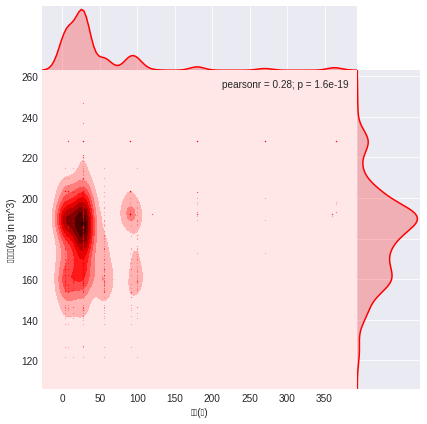

In [8]:
# 元のデータの分布をみてみましょう。ここでは材齢と単位水量について可視化してみます。
feat_1 = '材齢(日)'
feat_2 = '単位水量(kg in m^3)'

graph = sns.jointplot(feat_1, feat_2, data=X_train,
                      kind="kde", color="r", space=0)

graph.x = X_train[feat_1]
graph.y = X_train[feat_2]
graph.plot_joint(plt.scatter, c='r', s=0.01)
plt.show()

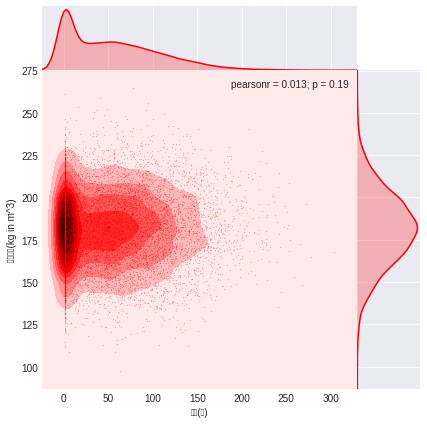

In [9]:
# 正規分布から生成したデータの分布をみてみましょう。ここでは材齢と単位水量について可視化してみます。
feat_1 = '材齢(日)'
feat_2 = '単位水量(kg in m^3)'

graph = sns.jointplot(feat_1, feat_2, data=X_artificial,
                      kind="kde", color="r", space=0)

graph.x = X_artificial[feat_1]
graph.y = X_artificial[feat_2]
graph.plot_joint(plt.scatter, c='r', s=0.01)
plt.show()

In [10]:
pred = pd.read_csv(
    '../input/concrete_regression_ENET_Blender_(13+26+27)_(68)_63.98_Informative_Features_concrete_artificial_10000.csv', index_col=0)

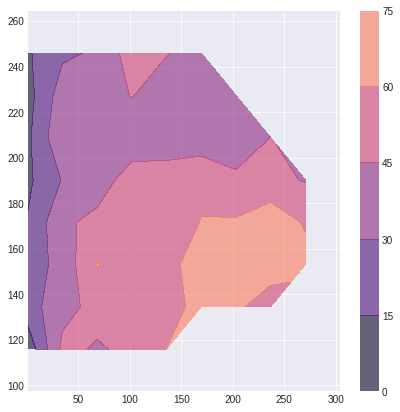

In [11]:
# 特徴空間（2D）における強度予測値の分布を可視化してみます
x = np.linspace(X_artificial[feat_1].min(),
                X_artificial[feat_1].max(), 10)
y = np.linspace(X_artificial[feat_2].min(),
                X_artificial[feat_2].max(), 10)

z = griddata((X_artificial[feat_1].values, X_artificial[feat_2].values),
             pred.Prediction.values, (x[None, :], y[:, None]), method='linear')

plt.figure(figsize=[7, 7])
plt.contourf(x, y, z, 5, alpha=.6, cmap=plt.cm.magma)
plt.colorbar()
plt.clim(pred.Prediction.min(), pred.Prediction.max())
plt.show()

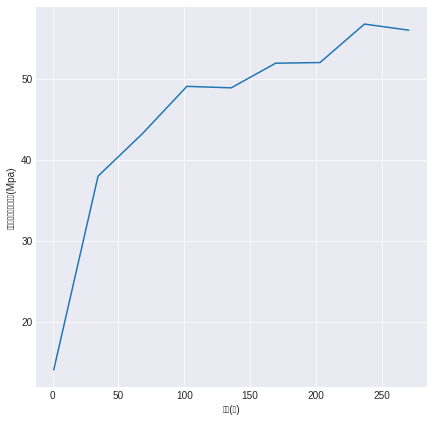

In [12]:
plt.figure(figsize=[7, 7])
plt.plot(x, np.nanmean(z, axis=0))
plt.xlabel(feat_1)
plt.ylabel('コンクリート圧縮強度(Mpa)')
plt.show()

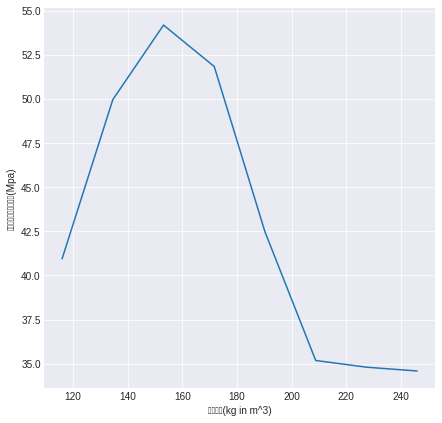

In [13]:
plt.figure(figsize=[7, 7])
plt.plot(y, np.nanmean(z, axis=1))
plt.xlabel(feat_2)
plt.ylabel('コンクリート圧縮強度(Mpa)')
plt.show()